In [1]:

# importing our functions
from utilities import coords_to_bins, add_team_possession, add_adjusted_eventSec
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm
import pickle
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
bins = (16,12)

In [3]:
# load data - store it in train dataframe

# Loading data for the English League
with open('events_England.json') as f:
    data_England = json.load(f)

# Converting the laoded into datframe
event_England = pd.DataFrame(data_England)
event_England['score_17_18'] = 79.605

event_England



,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409,79.605
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232,79.605
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410,79.605
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234,79.605


In [4]:
# Loading data for the English League
with open('events_Spain.json') as f:
    data_Spain = json.load(f)

# Converting the laoded into datframe
event_Spain = pd.DataFrame(data_Spain)
event_Spain['score_17_18'] = 106.998

event_Spain

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419,106.998
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418,106.998
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420,106.998
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421,106.998
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422,106.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [5]:
# Loading data for the English League
with open('events_Italy.json') as f:
    data_Italy = json.load(f)

# Converting the laoded into datframe
event_Italy = pd.DataFrame(data_Italy)
event_Italy['score_17_18'] = 76.249

event_Italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957,76.249
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958,76.249
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959,76.249
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960,76.249
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961,76.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,76.249
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,76.249


In [6]:
# Loading data for the English League
with open('events_Germany.json') as f:
    data_Germany = json.load(f)

# Converting the laoded into datframe
event_Germany = pd.DataFrame(data_Germany)
event_Germany['score_17_18'] = 71.427

event_Germany

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442,71.427
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443,71.427
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444,71.427
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445,71.427
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446,71.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867,71.427
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788,71.427
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868,71.427
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790,71.427


In [7]:
# Loading data for the French League
with open('events_France.json') as f:
    data_France = json.load(f)

# Converting the laoded into datframe
event_France = pd.DataFrame(data_France)
event_France['score_17_18'] = 56.415

event_France

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,Pass,3799,1H,1.935181,85,176505119,56.415
1,8,High pass,[{'id': 1801}],29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,Pass,3799,1H,3.599295,83,176505121,56.415
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",253784,"[{'y': 74, 'x': 68}, {'y': 54, 'x': 72}]",2500686,Duel,3799,1H,6.827043,10,176505122,56.415
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",56441,"[{'y': 26, 'x': 32}, {'y': 46, 'x': 28}]",2500686,Duel,3772,1H,6.985577,10,176505017,56.415
4,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",366760,"[{'y': 54, 'x': 72}, {'y': 55, 'x': 73}]",2500686,Duel,3799,1H,9.511272,11,176505124,56.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632802,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",405977,"[{'y': 65, 'x': 87}, {'y': 100, 'x': 100}]",2501065,Shot,19830,2H,2821.203869,100,253316980,56.415
632803,9,Save attempt,"[{'id': 101}, {'id': 1208}, {'id': 1802}]",25521,"[{'y': 0, 'x': 0}, {'y': 35, 'x': 13}]",2501065,Save attempt,3795,2H,2824.817116,91,253316978,56.415
632804,8,Simple pass,[{'id': 1801}],295761,"[{'y': 52, 'x': 50}, {'y': 47, 'x': 44}]",2501065,Pass,3795,2H,2888.383858,85,253316981,56.415
632805,8,Simple pass,[{'id': 1801}],249926,"[{'y': 47, 'x': 44}, {'y': 8, 'x': 41}]",2501065,Pass,3795,2H,2889.654402,85,253316982,56.415


In [8]:
event_data = pd.concat([event_England, event_France, event_Germany, event_Italy, event_Spain])

# Reset the index of the resulting dataframe
event_data = event_data.reset_index(drop=True)
event_data


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998


In [9]:
data = add_adjusted_eventSec(event_data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671,106.998,5646.463117
3071391,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673,106.998,5647.901186
3071392,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674,106.998,5649.484387
3071393,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698,106.998,5650.474858


In [10]:
data = add_team_possession(data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5693.313549,0.627653,3475.451269
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,5698.174956,4.861407,3480.312676
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,5746.059044,46.240805,3526.553481
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,5748.066821,0.889295,3527.442776


In [11]:
data['possession_percent'] = data['team_possession']/data['adjusted_eventSec']

data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,79.605,2.758649,2.758649,2.758649,1.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,79.605,4.946850,2.188201,4.946850,1.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,79.605,6.542188,1.595338,6.542188,1.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,79.605,8.143395,1.601207,8.143395,1.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,79.605,10.302366,2.158971,10.302366,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442727,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,76.249,5693.313549,0.627653,3475.451269,0.610444
2442728,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,76.249,5698.174956,4.861407,3480.312676,0.610777
2442731,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,76.249,5746.059044,46.240805,3526.553481,0.613734
2442733,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,76.249,5748.066821,0.889295,3527.442776,0.613675


# Filtering out all the shots from our dataset

In [12]:
# Filtering out all the shots from our dataset
shots_df = data[data['subEventName']=='Shot'].reset_index(drop=True)

shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,score_17_18,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,79.605,94.595788,0.634553,72.105703,0.762251
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,79.605,425.824035,2.064568,219.635022,0.515788
2,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,79.605,815.462015,1.457973,390.934751,0.479403
3,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",7945,"[{'y': 39, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1286.061650,100,177959606,79.605,1286.061650,0.901786,708.364059,0.550801
4,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",49876,"[{'y': 36, 'x': 69}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1301.831901,100,177959611,79.605,1301.831901,3.293762,720.425881,0.553394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542,76.249,4027.109364,0.181087,2474.514668,0.614464
40457,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586,76.249,4126.806901,2.819081,2542.031272,0.615980
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910,76.249,4940.110866,1.643393,3023.610571,0.612053
40459,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961,76.249,5242.328425,3.964910,3234.302277,0.616959


### I included all shots in the DataFrame, in the last version, I excluded headers.

In [13]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y', 'score_17_18', 'Match_Period', 'possession_percent', 'time_played'])

for i, shot in shots_df.iterrows():
     header=0
     for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
     if not(header):
    # Process all shots, including headers
        shots_model.at[i, 'X'] = shot['positions'][0]['x']
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']

    
    # Was it a goal
        shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
        # Tags contain that its a goal
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1
    
    # Adding match half, score_teams, possession_percent
        shots_model.at[i, 'Match_Period'] = shot['matchPeriod']
        shots_model.at[i, 'score_17_18'] = shot['score_17_18']
        shots_model.at[i, 'possession_percent'] = shot['possession_percent']
        shots_model.at[i, 'time_played'] = shot['adjusted_eventSec']


shots_model


,Goal,X,Y,score_17_18,Match_Period,possession_percent,time_played
0,1,88,41,79.605,1H,0.762251,94.595788
1,0,81,33,79.605,1H,0.515788,425.824035
2,0,75,30,79.605,1H,0.479403,815.462015
3,0,90,39,79.605,1H,0.550801,1286.06165
4,0,69,36,79.605,1H,0.553394,1301.831901
...,...,...,...,...,...,...,...
40456,0,95,45,76.249,2H,0.614464,4027.109364
40457,0,93,38,76.249,2H,0.61598,4126.806901
40458,1,90,46,76.249,2H,0.612053,4940.110866
40459,0,79,32,76.249,2H,0.616959,5242.328425


In [14]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,score_17_18,possession_percent,time_played,1H,2H
0,1,88,41,79.605,0.762251,94.595788,1,0
1,0,81,33,79.605,0.515788,425.824035,1,0
2,0,75,30,79.605,0.479403,815.462015,1,0
3,0,90,39,79.605,0.550801,1286.06165,1,0
4,0,69,36,79.605,0.553394,1301.831901,1,0
...,...,...,...,...,...,...,...,...
33937,0,95,45,76.249,0.614464,4027.109364,0,1
33938,0,93,38,76.249,0.61598,4126.806901,0,1
33939,1,90,46,76.249,0.612053,4940.110866,0,1
33940,0,79,32,76.249,0.616959,5242.328425,0,1


In [15]:
shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, '1H': int, '2H': int, 'score_17_18': float, 'possession_percent':float, 'time_played': float})

#  checking our datatypes
shots_model.dtypes

Goal                    int32
X                     float64
Y                     float64
score_17_18           float64
possession_percent    float64
time_played           float64
1H                      int32
2H                      int32
dtype: object

In [16]:
shots_model['bins'] =coords_to_bins(shots_model, 'X', 'Y' , bins)
shots_model

,Goal,X,Y,score_17_18,possession_percent,time_played,1H,2H,bins
0,1,88.0,41.0,79.605,0.762251,94.595788,1,0,172
1,0,81.0,33.0,79.605,0.515788,425.824035,1,0,147
2,0,75.0,30.0,79.605,0.479403,815.462015,1,0,147
3,0,90.0,39.0,79.605,0.550801,1286.061650,1,0,172
4,0,69.0,36.0,79.605,0.553394,1301.831901,1,0,136
...,...,...,...,...,...,...,...,...,...
33937,0,95.0,45.0,76.249,0.614464,4027.109364,0,1,185
33938,0,93.0,38.0,76.249,0.615980,4126.806901,0,1,172
33939,1,90.0,46.0,76.249,0.612053,4940.110866,0,1,173
33940,0,79.0,32.0,76.249,0.616959,5242.328425,0,1,147


In [17]:
# we will convert bins to one-hot encoded columns, making it suitable for machine learning models 
# or other analytical purposes.

# Perform one-hot encoding for bins column
one_hot = pd.get_dummies(shots_model['bins'], prefix='bin')

# Merge one-hot encoded columns back with the original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

# Drop the original 'bins' column
shots_model.drop('bins', axis=1, inplace=True)

# Resetting the index of the DataFrame
shots_model = shots_model.reset_index(drop=True)

# Finalized DataFrame
shots_model

       Goal     X     Y  score_17_18  possession_percent  time_played  1H  2H  \
0         1  88.0  41.0       79.605            0.762251    94.595788   1   0   
1         0  81.0  33.0       79.605            0.515788   425.824035   1   0   
2         0  75.0  30.0       79.605            0.479403   815.462015   1   0   
3         0  90.0  39.0       79.605            0.550801  1286.061650   1   0   
4         0  69.0  36.0       79.605            0.553394  1301.831901   1   0   
...     ...   ...   ...          ...                 ...          ...  ..  ..   
33937     0  95.0  45.0       76.249            0.614464  4027.109364   0   1   
33938     0  93.0  38.0       76.249            0.615980  4126.806901   0   1   
33939     1  90.0  46.0       76.249            0.612053  4940.110866   0   1   
33940     0  79.0  32.0       76.249            0.616959  5242.328425   0   1   
33941     0  93.0  43.0       76.249            0.613313  5454.944190   0   1   

       bin_4  bin_5  ...  b

In [18]:
# add missing bins to the dataframe
all_bins = [f'bin_{i}' for i in range(bins[0]*bins[1])]
# Ajoutez les colonnes manquantes avec des zéros
for col in all_bins:
    if col not in shots_model.columns:
        shots_model[col] = 0

shots_model        

,Goal,X,Y,score_17_18,possession_percent,time_played,1H,2H,bin_4,bin_5,...,bin_65,bin_68,bin_69,bin_70,bin_79,bin_82,bin_83,bin_93,bin_180,bin_191
0,1,88.0,41.0,79.605,0.762251,94.595788,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,81.0,33.0,79.605,0.515788,425.824035,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,75.0,30.0,79.605,0.479403,815.462015,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,90.0,39.0,79.605,0.550801,1286.061650,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,69.0,36.0,79.605,0.553394,1301.831901,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,95.0,45.0,76.249,0.614464,4027.109364,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
33938,0,93.0,38.0,76.249,0.615980,4126.806901,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
33939,1,90.0,46.0,76.249,0.612053,4940.110866,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
33940,0,79.0,32.0,76.249,0.616959,5242.328425,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
shots_model.drop(['X','Y', '1H'], axis=1, inplace=True)


shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model



,Goal,score_17_18,possession_percent,time_played,2H,bin_4,bin_5,bin_6,bin_7,bin_9,...,bin_65,bin_68,bin_69,bin_70,bin_79,bin_82,bin_83,bin_93,bin_180,bin_191
0,1,79.605,0.762251,94.595788,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,79.605,0.515788,425.824035,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,79.605,0.479403,815.462015,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,79.605,0.550801,1286.061650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,79.605,0.553394,1301.831901,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,76.249,0.614464,4027.109364,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33938,0,76.249,0.615980,4126.806901,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33939,1,76.249,0.612053,4940.110866,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33940,0,76.249,0.616959,5242.328425,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# The baseline 

In [20]:
basic_shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y'])

for i, shot in shots_df.iterrows():
     header=0
     for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
     if not(header):
    # Process all shots, including headers
        basic_shots_model.at[i, 'X'] = shot['positions'][0]['x']
        basic_shots_model.at[i, 'Y'] = shot['positions'][0]['y']

    
    # Was it a goal
        basic_shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
        # Tags contain that its a goal
            if shottags['id'] == 101:
                basic_shots_model.at[i, 'Goal'] = 1

basic_shots_model

,Goal,X,Y
0,1,88,41
1,0,81,33
2,0,75,30
3,0,90,39
4,0,69,36
...,...,...,...
40456,0,95,45
40457,0,93,38
40458,1,90,46
40459,0,79,32


In [21]:
basic_shots_model['bins'] = coords_to_bins(basic_shots_model, 'X', 'Y' , bins)

basic_shots_model.drop(['X','Y'], axis=1, inplace=True)


basic_shots_model = basic_shots_model.reset_index(drop=True)

# Finalized dataframe
basic_shots_model

,Goal,bins
0,1,172
1,0,147
2,0,147
3,0,172
4,0,136
...,...,...
33937,0,185
33938,0,172
33939,1,173
33940,0,147


In [22]:
# 1. Diviser les données en ensemble d'entraînement et de test
train_data, test_data = train_test_split(basic_shots_model, test_size=0.25, random_state=42)

# 2. Calculer la probabilité de but pour chaque bin dans l'ensemble d'entraînement
bin_probabilities = train_data.groupby('bins')['Goal'].mean().reset_index()
bin_probabilities.columns = ['bins', 'goal_prob']

# 3. Assigner les probabilités baselines aux données d'entraînement et de test
train_data = train_data.merge(bin_probabilities, on='bins', how='left')
test_data = test_data.merge(bin_probabilities, on='bins', how='left')

# 4. Remplir les valeurs manquantes avec une valeur par défaut (0)
train_data['goal_prob'].fillna(0, inplace=True)
test_data['goal_prob'].fillna(0, inplace=True)

# S'assurer que 'Goal' est de type binaire (0 ou 1) et que les prédictions sont en float
y_train = train_data['Goal'].astype(int)  # Convertir en entier si ce n'est pas déjà le cas
y_train_predict = train_data['goal_prob'].astype(float)
y_test = test_data['Goal'].astype(int)  # Convertir en entier si ce n'est pas déjà le cas
y_pred_baseline = test_data['goal_prob'].astype(float)

# 5. Calculer le Brier score pour la baseline sur l'ensemble d'entraînement et de test
brier_baseline_train = brier_score_loss(y_train, y_train_predict)
brier_baseline_test = brier_score_loss(y_test, y_pred_baseline)

print(f"Brier Score - Baseline (Train): {brier_baseline_train}")
print(f"Brier Score - Baseline (Test): {brier_baseline_test}")

Brier Score - Baseline (Train): 0.08004645114983983
Brier Score - Baseline (Test): 0.07707954503400052


# Second Model : Xgboost

In [23]:
# Create the target variable Y
y = shots_model['Goal']
y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int32

In [24]:
# Create the target variable Y
y = shots_model['Goal']
# Create the features X by dropping the 'Goal' column
X = shots_model.drop(columns=['Goal'])

In [25]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [27]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.712323540633346

In [53]:
# Définir l'espace de recherche pour BayesSearchCV
search_space = {
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_depth': Integer(2, 7),
    'n_estimators': Integer(10, 500),
    'scale_pos_weight': Real(1, scale_pos_weight)
}

In [54]:
# Démarrer le chronomètre
start_time = time.time()

# Effectuer la validation croisée imbriquée avec BayesSearchCV
bayes_search = BayesSearchCV(estimator=xgb_model, search_spaces=search_space, scoring = 'neg_brier_score', n_iter=30, cv=cv_inner, n_jobs=-1, verbose=2)
scores_xg = cross_val_score(bayes_search, X_train, y_train, cv=cv_outer, scoring='neg_brier_score', n_jobs=-1)

# Ajuster le meilleur modèle sur l'ensemble d'entraînement
bayes_search.fit(X_train, y_train)
best_xgb_model = bayes_search.best_estimator_

# Arrêter le chronomètre
stop_time = time.time()

# Temps d'entraînement
xgb_training_time = stop_time - start_time

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [55]:
# Afficher les meilleurs paramètres et le temps d'entraînement
print("Best parameters: ", bayes_search.best_params_)
print("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  OrderedDict([('learning_rate', 0.1), ('max_depth', 2), ('n_estimators', 354), ('scale_pos_weight', 1.0)])
Model Training Time: 1308.052 seconds


In [56]:
 #Brier score for xgboost on training data
xgb_brs_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (f"{xgb_brs_train} is the Brier score on training data" )

0.07947255120164805 is the Brier score on training data


In [57]:
# On testing data
xgb_brs_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (f"{xgb_brs_test} is the Brier score on testing data" )

0.0771999805631968 is the Brier score on testing data


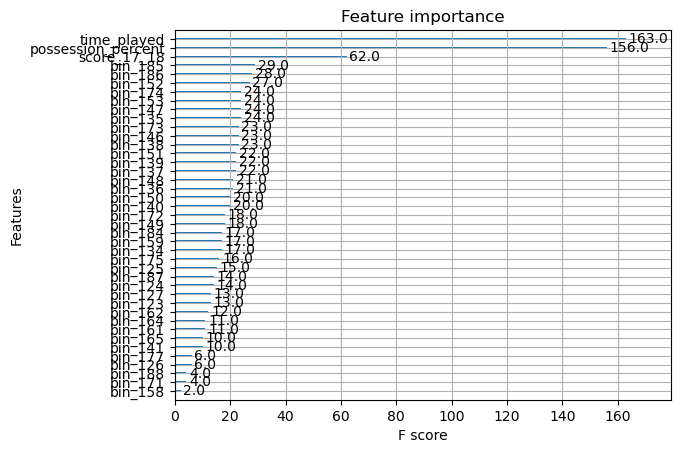

In [58]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

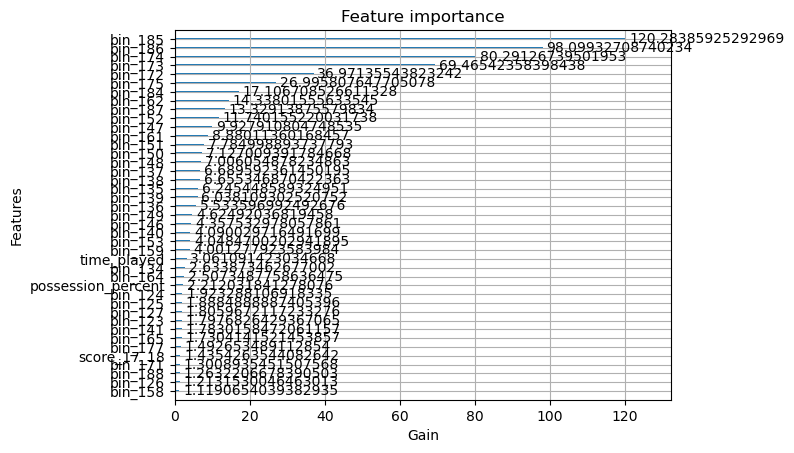

In [59]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

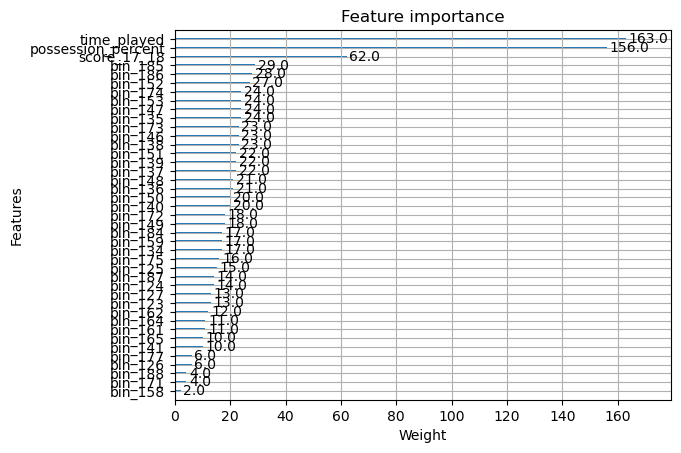

In [60]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

In [61]:

# Brier score for four models on training data
brs_train = [ xgb_brs_train, brier_baseline_train]
# Brier score for four models on test data
brs_test = [xgb_brs_test, brier_baseline_test ]
# Model training time
train_time =[xgb_training_time/60, 0.1/60]

In [62]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost', 'baseline'],
                          'Training Brier scores': brs_train,
                          'Testing Brier scores': brs_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =4).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Brier scores,Testing Brier scores,Training Time (mins)
Model Name,,,
XG Boost,0.0795,0.0772,21.8009
baseline,0.0800,0.0771,0.0017


In [38]:
#pickle.dump(best_xgb_model, open('xG_model.pkl', 'wb'))